# 📊 Tech Challenge - Análise e Previsão de Fatores de Estresse em Estudantes

## 📑 Sumário
1. [📝 Definição do Problema](#1-📝-Definição-do-Problema)
2. [📥 Coleta e Armazenamento](#2-📥-Coleta-e-Armazenamento)
3. [🔎 Análise Exploratória](#3-🔎-Análise-Exploratória)
4. [⚙️ Pré-processamento](#4-⚙️-Pré-processamento)
5. [🤖 Modelagem](#5-🤖-Modelagem)
6. [🚀 Deploy](#6-🚀-Deploy)

## 1. 📝 Definição do problema

* **Problema de Negócio:** Desenvolver uma solução que permita a instituições de ensino identificar estudantes com risco de estresse elevado, possibilitando a criação de programas de apoio mais direcionados e eficazes.
* **Objetivo Técnico:** O problema foi enquadrado como um desafio de **Classificação Multiclasse**. O objetivo é treinar um modelo de Machine Learning para prever o nível de estresse de um estudante em uma de três categorias (0: baixo, 1: médio, 2: alto), utilizando a coluna `stress_level` como variável-alvo.

## 2. 📥 Coleta e Armazenamento

#### 📌 Coleta de Dados

* **Fonte dos Dados:** Foi utilizado um dataset público da plataforma Kaggle, chamado "Student Stress Factors - A Comprehensive Analysis".
* **Justificativa:** A utilização de um dataset já existente foi uma decisão estratégica para otimizar o tempo e concentrar os esforços do projeto nas etapas de Análise, Modelagem e Deploy, que são o foco do desafio.

#### 📌 Armazenamento dos Dados

* **Solução Adotada:** Para simular um ambiente de produção e garantir a reprodutibilidade, os dados foram armazenados em um sistema de armazenamento de objetos local (MinIO)].
* **Processo:** Um bucket chamado `student-stress` foi criado no servidor MinIO , e o dataset `StressLevelDataset.csv` foi carregado, tornando-se acessível via serviço para a etapa de análise.

In [1]:
# Importação de Bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import boto3
from io import BytesIO

# Importar dicionário de tradução dos nomes das features
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from config import FEATURE_TRANSLATOR


# Configurações de estilo para os gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Configurações de conexão com o MinIO
MINIO_ENDPOINT = "127.0.0.1:9000"
MINIO_ACCESS_KEY = "minioadmin"  
MINIO_SECRET_KEY = "minioadmin"  
BUCKET_NAME = "student-stress"
OBJECT_NAME = "StressLevelDataset.csv"

# Criar um cliente S3 compatível para interagir com o MinIO
s3_client = boto3.client(
    "s3",
    endpoint_url=f"http://{MINIO_ENDPOINT}",
    aws_access_key_id=MINIO_ACCESS_KEY,
    aws_secret_access_key=MINIO_SECRET_KEY,
    aws_session_token=None,
    config=boto3.session.Config(signature_version="s3v4"),
)

# Tentar carregar o objeto do bucket
try:
    response = s3_client.get_object(Bucket=BUCKET_NAME, Key=OBJECT_NAME)
    # Ler o conteúdo do objeto em um DataFrame do Pandas
    # O BytesIO trata os bytes do objeto como um arquivo em memória
    df = pd.read_csv(BytesIO(response["Body"].read()))
    print("Dataset carregado com sucesso do MinIO!")
except Exception as e:
    print(f"Erro ao carregar o dataset do MinIO: {e}")

Dataset carregado com sucesso do MinIO!


## 3. 🔎 Análise Exploratória

#### 📌 Análise Estrutural e de Qualidade
* **Objetivo:** Ter uma visão geral da estrutura do dataset e verificar a integridade dos dados (nulos e duplicados).

In [4]:
# --- Título para a Célula de Análise Estrutural ---
print("=" * 60)
print("     Análise Estrutural e Qualidade dos Dados")
print("=" * 60)

# 1. Verificar as dimensões do dataset
print(
    f"\nO dataset é composto por {df.shape[0]} linhas (registros) e {df.shape[1]} colunas (features).\n"
)
print("-" * 60)

# 2. Criar um DataFrame com informações de tipos de dados e valores nulos
print("Análise de Tipos de Dados e Valores Nulos por Coluna:\n")
info_df = pd.DataFrame(
    {
        "Tipo de Dado": df.dtypes,
        "Valores Não Nulos": df.count(),
        "Valores Nulos": df.isnull().sum(),
        "% Nulos": (df.isnull().sum() / df.shape[0]) * 100,
    }
).sort_values(by="% Nulos", ascending=False)

# Exibe o DataFrame de informações formatado
with pd.option_context("display.max_rows", None, "display.width", 1000):
    display(info_df)

print("-" * 60)

# 3. Verificar a existência de linhas completamente duplicadas
num_duplicates = df.duplicated().sum()
if num_duplicates > 0:
    print(f"\nAlerta: Foram encontradas {num_duplicates} linhas duplicadas no dataset.")
else:
    print("\nAnálise de Duplicatas: Nenhuma linha duplicada foi encontrada.")

print("=" * 60)

     Análise Estrutural e Qualidade dos Dados

O dataset é composto por 1100 linhas (registros) e 21 colunas (features).

------------------------------------------------------------
Análise de Tipos de Dados e Valores Nulos por Coluna:



,Tipo de Dado,Valores Não Nulos,Valores Nulos,% Nulos
anxiety_level,int64,1100,0,0.0
basic_needs,int64,1100,0,0.0
bullying,int64,1100,0,0.0
extracurricular_activities,int64,1100,0,0.0
peer_pressure,int64,1100,0,0.0
social_support,int64,1100,0,0.0
future_career_concerns,int64,1100,0,0.0
teacher_student_relationship,int64,1100,0,0.0
study_load,int64,1100,0,0.0
academic_performance,int64,1100,0,0.0


------------------------------------------------------------

Análise de Duplicatas: Nenhuma linha duplicada foi encontrada.


#### 📌 Amostra dos Dados e Estatísticas Descritivas
* **Objetivo:** Inspecionar o conteúdo das linhas e obter um resumo estatístico para entender a distribuição e a escala das variáveis numéricas.

In [5]:
# --- Título para a Célula de Análise Descritiva ---
print("=" * 70)
print("        Análise Descritiva e Visualização Inicial dos Dados")
print("=" * 70)

# 1. Visualizar as 5 primeiras linhas para entender a estrutura dos dados
print("\n1. Amostra dos Dados (5 Primeiras Linhas)")
print(
    "   Visualização para conferir a estrutura, nomes de colunas e exemplos de valores."
)
display(df.head())

# Adiciona um separador visual entre as seções
print("\n" + "-" * 70 + "\n")

# 2. Obter estatísticas descritivas para as colunas numéricas
print("2. Estatísticas Descritivas")
print(
    "   Resumo estatístico das variáveis numéricas (contagem, média, desvio padrão, etc.)."
)

# A transposição (.T) melhora a legibilidade quando há muitas colunas.
# O .style.format('{:.2f}') formata os números para 2 casas decimais.
descriptive_stats = df.describe().T
display(descriptive_stats.style.format("{:.2f}"))

print("\n" + "=" * 70)

        Análise Descritiva e Visualização Inicial dos Dados

1. Amostra dos Dados (5 Primeiras Linhas)
   Visualização para conferir a estrutura, nomes de colunas e exemplos de valores.


,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,...,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
0,14,20,0,11,2,1,2,4,2,3,...,2,3,2,3,3,2,3,3,2,1
1,15,8,1,15,5,3,1,4,3,1,...,2,1,4,1,5,1,4,5,5,2
2,12,18,1,14,2,1,2,2,2,2,...,2,2,3,3,2,2,3,2,2,1
3,16,12,1,15,4,3,1,3,4,2,...,2,2,4,1,4,1,4,4,5,2
4,16,28,0,7,2,3,5,1,3,2,...,3,4,3,1,2,1,5,0,5,1



----------------------------------------------------------------------

2. Estatísticas Descritivas
   Resumo estatístico das variáveis numéricas (contagem, média, desvio padrão, etc.).


,count,mean,std,min,25%,50%,75%,max
anxiety_level,1100.00,11.06,6.12,0.00,6.00,11.00,16.00,21.00
self_esteem,1100.00,17.78,8.94,0.00,11.00,19.00,26.00,30.00
mental_health_history,1100.00,0.49,0.50,0.00,0.00,0.00,1.00,1.00
depression,1100.00,12.56,7.73,0.00,6.00,12.00,19.00,27.00
headache,1100.00,2.51,1.41,0.00,1.00,3.00,3.00,5.00
blood_pressure,1100.00,2.18,0.83,1.00,1.00,2.00,3.00,3.00
sleep_quality,1100.00,2.66,1.55,0.00,1.00,2.50,4.00,5.00
breathing_problem,1100.00,2.75,1.40,0.00,2.00,3.00,4.00,5.00
noise_level,1100.00,2.65,1.33,0.00,2.00,3.00,3.00,5.00
living_conditions,1100.00,2.52,1.12,0.00,2.00,2.00,3.00,5.00



#### **Principais Conclusões da Inspeção:**

A análise estrutural, realizada com os comandos `.shape`, `.info()` e `.duplicated()`, revelou as seguintes conclusões:

* **Dimensões:** O conjunto de dados é composto por **1100 registros** e **21 colunas**.
* **Valores Ausentes:** Foi confirmado que **não há nenhum valor ausente (nulo)** em nenhuma das colunas. Isso nos poupa da necessidade de aplicar técnicas de imputação de dados.
* **Registros Duplicados:** A verificação confirmou que **não existem linhas duplicadas**, garantindo que cada registro é único.
* **Tipos de Dados:** Todas as colunas já estão em formato numérico (`int64`), o que simplifica a etapa de pré-processamento, pois não será necessário realizar *encodings* de variáveis categóricas textuais.

#### **Análise de Outliers e Natureza das Variáveis:**

A análise das estatísticas descritivas (`.describe()`) nos permite entender a natureza das nossas variáveis:

* **Natureza Ordinal:** Fica evidente que a maioria das features são ordinais, representando escalas fixas (majoritariamente de 0 a 5).
* **Tratamento de Outliers:** Considerando que os valores nos extremos dessas escalas (ex: 0 ou 5) são respostas válidas e representam os limites das opções disponíveis para os estudantes, a aplicação de técnicas de remoção de outliers seria inadequada. Tais valores são cruciais para o modelo entender os diferentes níveis de estresse e, portanto, **nenhuma ação de tratamento de outliers será realizada**.

#### **Conclusão da Etapa de Limpeza:**

O dataset está excepcionalmente limpo e bem estruturado. A fase de limpeza de dados é considerada **concluída**. Com a confiança na integridade dos dados, podemos prosseguir para a análise de distribuição das variáveis e suas correlações.

### 2. Análise de Comportamento dos Dados

Com a qualidade dos dados validada na etapa anterior, iniciamos agora a análise do comportamento das variáveis. O objetivo é extrair insights sobre as distribuições de dados e as relações entre os fatores pesquisados e o nível de estresse dos estudantes.

#### 2.1. Análise Univariada

A análise univariada foca em entender a distribuição de uma única variável por vez. Começaremos pela nossa variável mais importante: o alvo (`stress_level`).

##### Distribuição da Variável Alvo (`stress_level`)

Verificar a distribuição da variável alvo é fundamental em um problema de classificação. Isso nos permite identificar se as classes (0: baixo, 1: médio, 2: alto) estão balanceadas. Um desbalanceamento severo poderia enviesar o modelo, fazendo-o performar melhor para as classes mais frequentes.

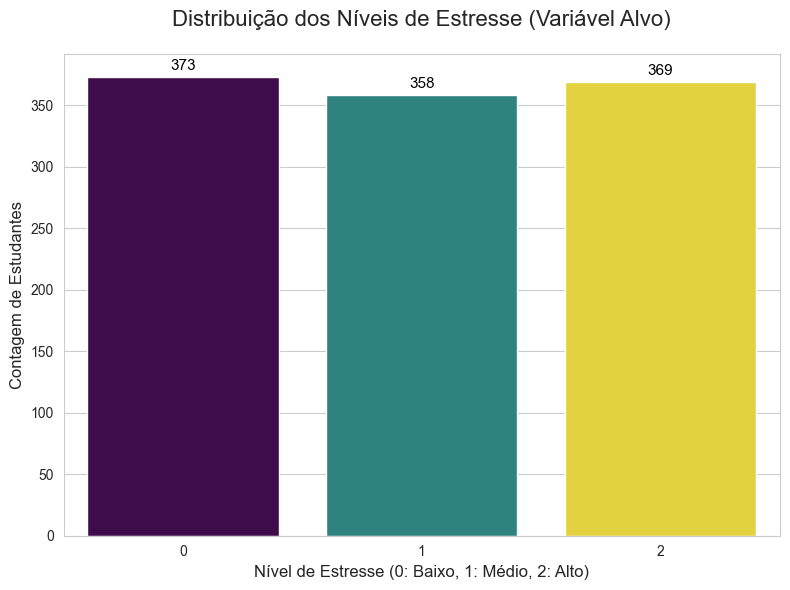

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define o estilo e inicializa a figura e os eixos do gráfico.
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))

# Cria um gráfico de contagem para a variável 'stress_level', atribuindo uma cor para cada nível.
sns.countplot(
    data=df,
    x="stress_level",
    hue="stress_level",
    palette="viridis",
    order=[0, 1, 2],
    legend=False,
    ax=ax,
)

# Itera sobre cada container de barras para adicionar os rótulos de contagem.
for container in ax.containers:
    ax.bar_label(container, padding=3, fontsize=11, color="black")

# Define os títulos e rótulos para os eixos do gráfico.
ax.set_title(
    "Distribuição dos Níveis de Estresse (Variável Alvo)",
    fontsize=16,
    pad=20,  # Controla a distância do título para o gráfico.
)
ax.set_xlabel("Nível de Estresse (0: Baixo, 1: Médio, 2: Alto)", fontsize=12)
ax.set_ylabel("Contagem de Estudantes", fontsize=12)

# Otimiza o espaçamento entre os elementos do gráfico.
plt.tight_layout()
plt.show()

#### Conclusão sobre a Variável-Alvo

A análise da distribuição da variável `stress_level` mostra que as três classes (0: Baixo, 1: Médio, 2: Alto) estão **muito bem balanceadas**. Com contagens de 373, 358 e 369 respectivamente, temos uma base sólida e imparcial para o treinamento do modelo de classificação, eliminando a necessidade de técnicas de balanceamento de classes.

##### Distribuição das Variáveis Preditivas (Features)

Agora, vamos visualizar a distribuição de cada variável preditiva para entender o perfil geral das respostas dos estudantes. Como a maioria das variáveis é ordinal (escalas de 0 a 5), gráficos de contagem são ideais.

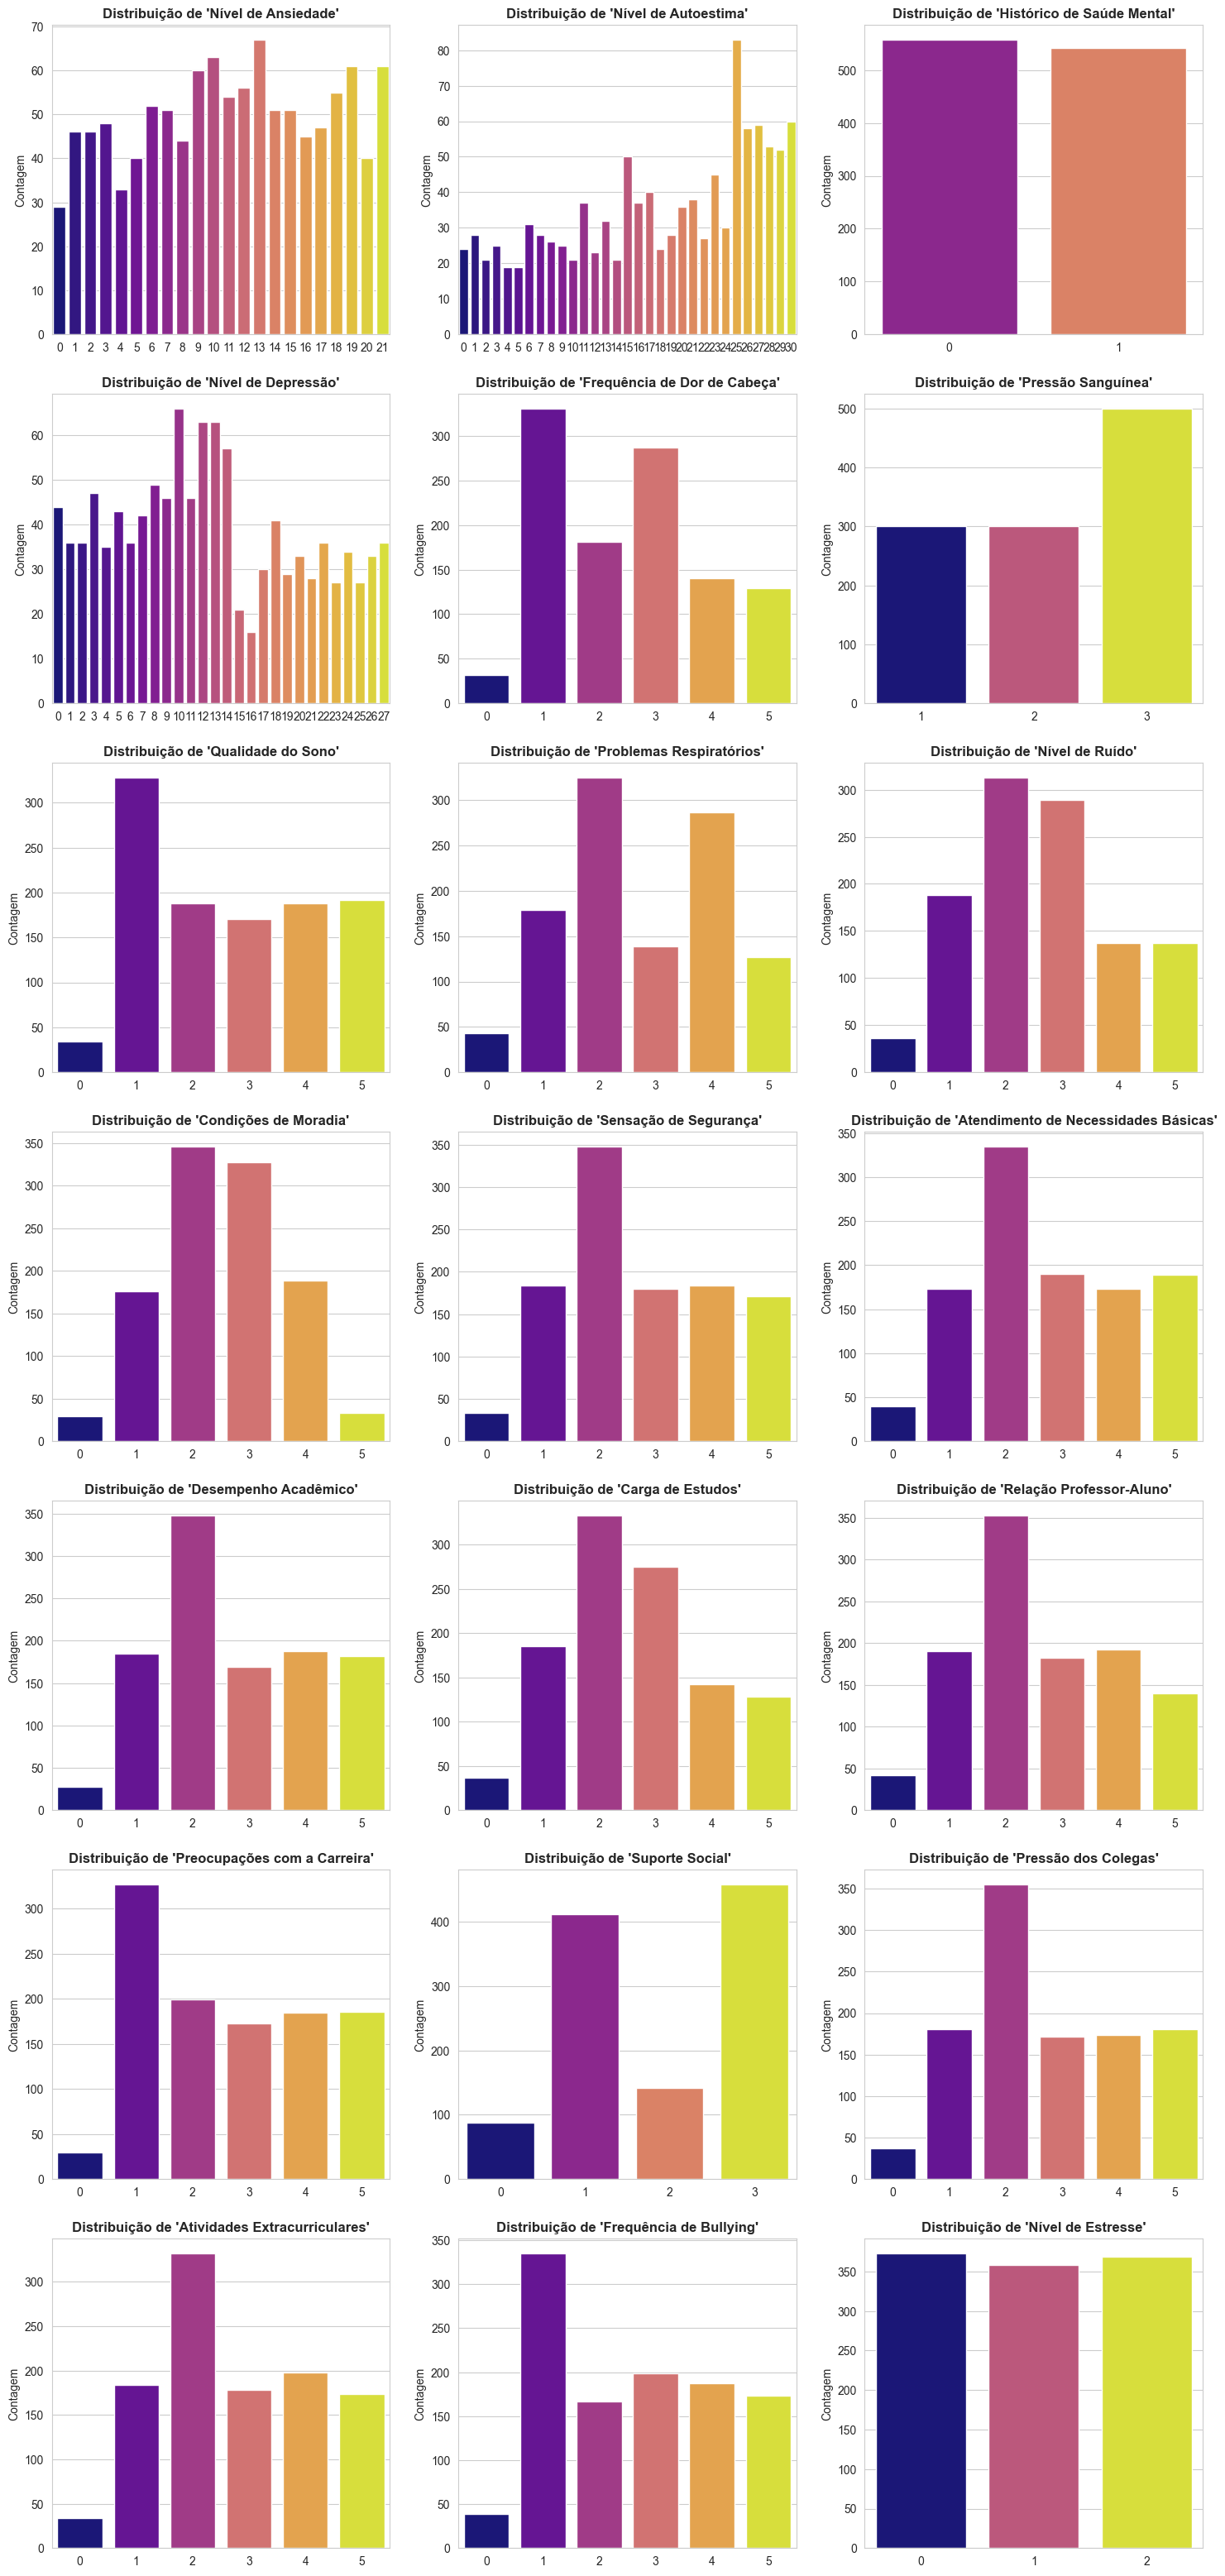

In [7]:
# --- Configurações Iniciais ---

# 1. Identificar as features (agora usamos as chaves do nosso dicionário)
features = list(FEATURE_TRANSLATOR.keys())

# 2. Definir a estrutura da grade de visualização (3 colunas)
n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols  # Cálculo robusto para o n° de linhas

# --- Criação dos Gráficos ---
# 3. Criar a figura e os eixos para os subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4.5))
axes = (
    axes.flatten()
)  # Transforma a matriz de eixos em um array 1D para facilitar a iteração

# 4. Gerar um gráfico de contagem para cada feature
for i, feature in enumerate(features):
    ax = axes[i]

    # Pega o nome traduzido do dicionário para usar no título
    titulo_grafico = FEATURE_TRANSLATOR.get(feature, feature)  # .get() é seguro

    sns.countplot(
        x=feature, data=df, ax=ax, palette="plasma", hue=feature, legend=False
    )
    ax.set_title(
        f"Distribuição de '{titulo_grafico}'", fontsize=12, weight="bold"
    )  
    ax.set_xlabel("")
    ax.set_ylabel("Contagem")

# 5. Ocultar os eixos que não foram utilizados na grade
# Itera sobre os eixos restantes a partir do final da lista de features
for i in range(len(features), len(axes)):
    axes[i].axis("off")

# --- Finalização ---
plt.tight_layout(pad=2.0)  # Ajusta o espaçamento para evitar sobreposição
plt.show()

**Observações Gerais e Conclusões da Análise Univariada das Features:**

A análise dos gráficos de distribuição nos permite traçar um perfil multifacetado dos estudantes. Agrupando as variáveis por contexto, podemos destacar as seguintes conclusões:

**1. Fatores Psicológicos e de Saúde Mental:**
* **`mental_health_history`**: A distribuição é notavelmente bimodal e equilibrada, revelando uma divisão quase igual na amostra entre estudantes com e sem um histórico clínico de saúde mental. A ausência de uma classe minoritária aqui é um dado importante.
* **`anxiety_level` e `depression`**: As distribuições são amplas e sem picos definidos, o que confirma a heterogeneidade da amostra. Isso indica que o modelo precisará lidar com um espectro completo de perfis, desde os assintomáticos até os com sintomas severos.
* **`self_esteem`**: A distribuição sugere uma tendência geral para uma autoestima de moderada a alta, com uma clara concentração de respostas em escores iguais ou superiores a 15. O pico notável no nível 25 pode indicar um subgrupo com autoconfiança particularmente elevada ou ser um artefato da escala de medição. 

**2. Fatores Acadêmicos:**
* **`academic_performance`**: A percepção sobre o desempenho acadêmico concentra-se no nível 2, indicando uma autoavaliação predominantemente "regular". Observa-se que poucos se classificam com desempenho muito baixo (nível 0). Por outro lado, uma parcela relevante se avalia nos níveis mais altos (4 e 5), o que sugere que a depressão pode não estar necessariamente associada ao desempenho escolar em si.
* **`study_load`**: A percepção de carga de estudos está concentrada nos níveis intermediários a altos (picos em 2 e 3), o que reforça a hipótese de um ambiente acadêmico exigente e pode ser um fator de pressão constante.
* **`teacher_student_relationship`**: O pico de respostas no nível 2 sugere que a relação com os professores é majoritariamente percebida como funcional ou neutra. A baixa frequência nos extremos (0 e 5) reforça sua interpretação de uma possível relação marcada mais pela distância do que por uma forte conexão ou conflito.

**3. Fatores de Bem-Estar e Ambiente:**
* **`living_conditions`**: A concentração nos níveis intermediários (2, 3 e 4) é um forte indicativo de que a maioria dos estudantes não enfrenta privações severas nem desfruta de luxo, alinhando-se a um perfil socioeconômico intermediário.
* **`safety` e `basic_needs`**: As distribuições indicam que a grande maioria se sente segura e com suas necessidades básicas atendidas, mas com uma percepção mais "razoável" (pico no nível 2) do que "excelente". A quase ausência de respostas no nível 0 é um sinal positivo.
* **`noise_level`**: A percepção de ruído no ambiente é concentrada nos níveis intermediários, sugerindo que um ambiente perfeitamente silencioso não é a realidade para a maioria.
* **`sleep_quality`**: A qualidade do sono emerge como um ponto de atenção crítico. A forte concentração em níveis baixos, com um pico expressivo no nível 1, indica que o sono de má qualidade é uma experiência comum e prevalente neste grupo..

**4. Fatores Sociais e de Relacionamento:**
* **`social_support`**: A distribuição bimodal é um insight fundamental. Ela revela dois grupos distintos e expressivos: um que percebe o apoio social como forte (pico no nível 3) e outro, igualmente significativo, que o considera insuficiente (pico no nível 1). Isso indica que o suporte social não é um fator uniformemente positivo na amostra.
* **`bullying`**: Contrariando uma expectativa comum, a distribuição indica que o bullying é uma experiência prevalente. O pico no nível 1 e as baixas ocorrências no nível 0 sugerem que a maioria dos estudantes já sofreu algum tipo de bullying, ainda que de baixa intensidade.
* **`peer_pressure`**: A pressão dos colegas é percebida majoritariamente com intensidade moderada (pico no nível 2), consolidando-se como um fator presente, mas não extremo, no cotidiano dos estudantes.

**5. Sintomas Fisiológicos e Preocupações Futuras:**
* **`blood_pressure`**: A pressão arterial se destaca como um indicador de saúde preocupante. A clara tendência de elevação na amostra, com quase metade dos estudantes no nível mais alto, é um forte sinal de alerta e um sintoma físico potencialmente ligado ao estresse crônico.
* **`headache` e `breathing_problem`**-: As distribuições indicam que estes são sintomas crônicos para a maioria. A baixa contagem no nível 0 (ausência de sintomas) é particularmente reveladora, sugerindo que dores de cabeça e dificuldades respiratórias, em diferentes graus, são condições normalizadas nesta população.

**6. Outros:**
* **`future_career_concerns`**: As preocupações com a carreira, embora presentes, parecem se concentrar em uma intensidade de baixa a moderada (picos nos níveis 1 e 2). Não parece ser o principal vetor de ansiedade quando comparado a outros fatores.
* **`extracurricular_activities`**: A maioria dos estudantes relata participação em alguma atividade extracurricular, com destaque para o nível 2. Essa tendência pode estar relacionada à sobrecarga de compromissos e ao sono insuficiente.

#### **Sumário do Perfil do Estudante**

Com base na análise refinada, podemos construir um perfil mais nítido e preocupante do estudante médio desta amostra:

Ele vive uma rotina acadêmica exigente, com uma autoavaliação de desempenho apenas regular, que parece cobrar um preço significativo em sua saúde. Sintomas físicos crônicos como dores de cabeça, problemas respiratórios e, mais alarmante, pressão arterial elevada, são comuns. Aliado a isso, a má qualidade do sono é uma realidade para a grande maioria.

O ambiente social é complexo e fonte de desafios. O bullying é uma experiência prevalente, e o suporte da rede social é polarizado: ou é forte, ou é percebido como insuficiente. O estudante típico pertence a um contexto socioeconômico intermediário, com suas necessidades básicas atendidas, mas lida com uma carga de estudos e atividades que pode estar contribuindo para seu esgotamento físico e mental.

### 2.2. Análise Bivariada

A análise bivariada explora a relação entre duas variáveis. Nosso foco principal será investigar como cada variável preditiva se relaciona com a nossa variável alvo, `stress_level`. Isso nos ajudará a identificar quais fatores parecem ter maior influência sobre o estresse.

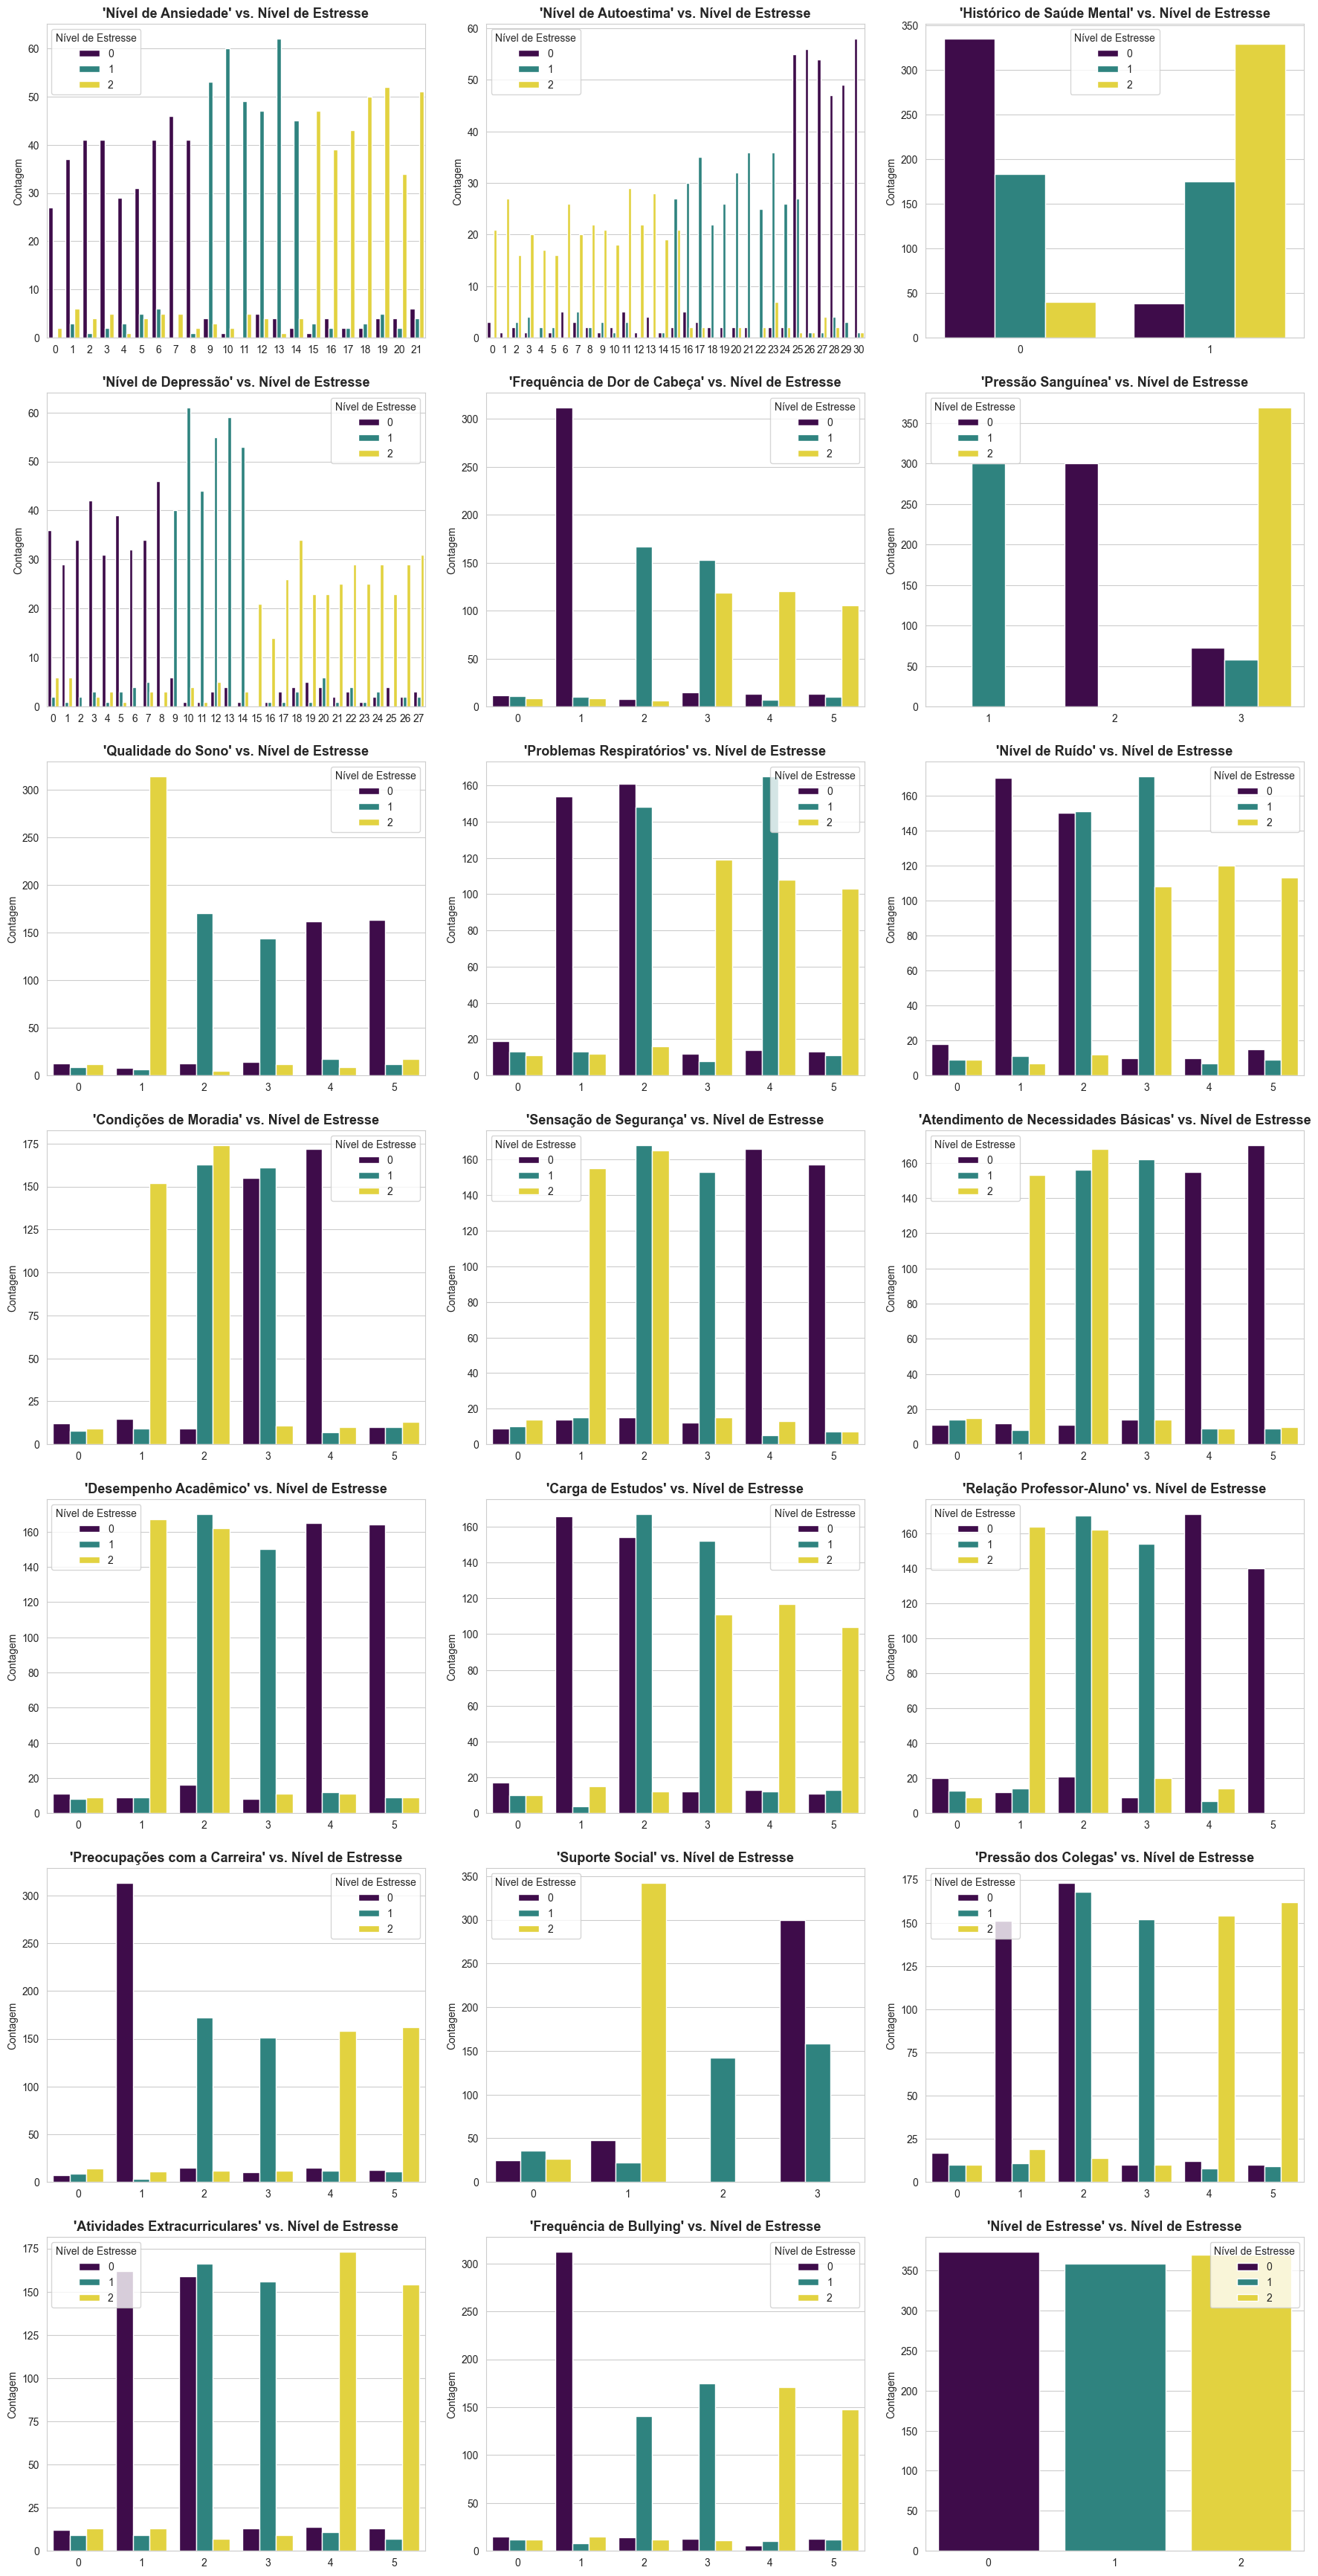

In [8]:
# Cria a figura e os eixos para os subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
axes = axes.flatten()

# Itera sobre cada feature para criar os gráficos
for i, feature in enumerate(features):
    ax = axes[i]

    # 1. Busca o nome da feature traduzida no dicionário.
    #    Se a feature não estiver no dicionário, será usado o nome original como fallback.
    titulo_traduzido = FEATURE_TRANSLATOR.get(feature, feature)

    # 2. Cria o gráfico de contagem, segmentado pela variável alvo
    sns.countplot(x=feature, data=df, hue="stress_level", ax=ax, palette="viridis")

    # 3. Define o título do gráfico usando a variável traduzida
    ax.set_title(
        f"'{titulo_traduzido}' vs. Nível de Estresse", fontsize=13, weight="bold"
    )

    ax.set_xlabel("")  # Remove o rótulo do eixo x para um visual mais limpo
    ax.set_ylabel("Contagem")
    ax.legend(title="Nível de Estresse")

# Oculta os eixos que não foram utilizados (versão otimizada)
for ax in axes[len(features) :]:
    ax.axis("off")

# Ajusta o layout para evitar sobreposição e exibe os gráficos
plt.tight_layout(pad=2.0)
plt.show()

**Observações Gerais e Conclusões da Análise Bivariada:**

Nesta fase, cruzamos cada variável preditiva com a nossa variável alvo (`stress_level`) para identificar padrões e a força da relação entre elas. Variáveis que mostram uma mudança clara na distribuição do estresse são fortes candidatas a serem bons preditores para o modelo de Machine Learning.

**1. Fatores Acadêmicos e de Carreira:**
* **`academic_performance`**: A **correlação negativa é muito clara**. Nos níveis mais altos de performance (4 e 5), o estresse de nível baixo (0) é predominante, enquanto os níveis médio (1) e alto (2) são praticamente inexistentes. A variável se mostra um forte preditor inverso do estresse.
* **`study_load`**: Confirma-se uma **forte correlação positiva**. O aumento da carga de estudos está diretamente associado a uma maior proporção de estresse elevado (nível 2), que se torna a classe dominante nos níveis mais altos da escala.
* **`teacher_student_relationship`**: Existe uma **correlação negativa visível**. Relações mais positivas com os professores estão associadas a uma menor incidência de estresse alto, sugerindo um efeito protetor.
* **`future_career_concerns` e `extracurricular_activities`**: Ambas as variáveis demonstram uma **forte correlação positiva**. Uma maior preocupação com a carreira e um maior envolvimento em atividades extracurriculares estão ligados a uma maior proporção de estresse elevado.

**2. Fatores Psicológicos e de Saúde Mental:**
* **`anxiety_level` e `depression`**: Como esperado, ambos mostram uma **correlação positiva fortíssima e linear**. Nos níveis mais baixos dessas escalas, o estresse é quase inexistente. Nos níveis mais altos, o estresse elevado domina completamente. A relação é tão direta que essas variáveis funcionarão como indicadores primários de estresse, sendo, muito provavelmente, as mais influentes no modelo.
* **`self_esteem`**: Apresenta uma **correlação negativa muito clara**. Quanto maior a autoestima, menor a incidência de estresse alto e maior a de estresse baixo.
* **`mental_health_history`**: A natureza binária da variável evidencia seu poder preditivo. O grupo com histórico de saúde mental (nível 1) apresenta uma proporção **significativamente maior** de estresse elevado em comparação ao grupo sem histórico (nível 0).

**3. Fatores Sociais e de Relacionamento:**
* **`social_support`**: A análise revela uma relação não linear interessante: o pico de estresse alto ocorre no nível 1 (suporte social insuficiente/insatisfatório), sendo ainda mais proeminente do que no nível 0 (ausência de suporte). Para os demais níveis (suporte adequado), o estresse é praticamente nulo. Isso sugere que a *percepção de um suporte falho* pode ser mais estressante do que a ausência total dele. No geral, a tendência predominante é uma **forte correlação negativa**.

* **`bullying`**: Apresenta uma das **correlações positivas mais fortes e diretas**. A proporção de estresse alto cresce de forma alarmante e progressiva com o aumento do nível de bullying.
* **`peer_pressure`**: Mostra uma **correlação positiva moderada**. A tendência de aumento do estresse com a maior pressão dos colegas é visível, embora menos acentuada do que no caso do bullying.

**4. Fatores de Bem-Estar e Ambiente:**
* **`living_conditions`, `safety`, `basic_needs` e `sleep_quality`**: Todas as três mostram uma **correlação negativa consistente**. Melhores condições de vida, maior segurança, necessidades básicas bem atendidas e maior qualidade de sono estão claramente associadas a níveis mais baixos de estresse.
* **`noise_level`**: Enquanto com níveis altos de barulho o efeito é oposto, a tendência é uma **forte correlação positiva**.

**5. Sintomas Fisiológicos:**
* **`headache` e `breathing_problem`**: Ambas têm uma **correlação positiva muito forte**. A maior frequência desses sintomas está diretamente ligada a uma maior proporção de estresse alto.
* **`blood_pressure`**: A relação é **extremamente forte e praticamente determinística**. O estresse de nível alto está concentrado exclusivamente no grupo com o maior nível de pressão arterial, tornando esta variável um diferenciador muito claro entre as classes.

---

### **Sumário e Ranking de Preditores Potenciais**

A análise bivariada confirmou que o dataset é rico em preditores. Quase todas as variáveis mostram uma relação clara com o nível de estresse, o que é um excelente prognóstico para a modelagem. Com base na força e clareza dessas relações, podemos classificar as variáveis da seguinte forma:

* **Preditores de Primeira Ordem (Relação Extremamente Forte e Direta):**
    * `anxiety_level`, `depression`: A correlação é tão forte que são quase proxies para o próprio estresse.
    * `blood_pressure`: Atua como um divisor de águas, isolando grande parte da classe de estresse alto.
    * `bullying`, `social_support`, `self_esteem`: Fatores psicossociais com impacto massivo e direto.

* **Preditores de Segunda Ordem (Relação Forte e Consistente):**
    * `academic_performance`, `study_load`: A dupla central da vida acadêmica, com efeitos opostos e claros.
    * `sleep_quality`: Fator de bem-estar fundamental com forte correlação.
    * `headache`, `breathing_problem`: Sintomas físicos que andam de mãos dadas com o estresse.
    * `future_career_concerns`, `mental_health_history`: Indicadores de preocupação e predisposição.

* **Preditores de Terceira Ordem (Relação Clara, porém mais Moderada):**
    * `living_conditions`, `safety`, `basic_needs`: Fatores ambientais que formam a base do bem-estar.
    * `teacher_student_relationship`, `peer_pressure`, `extracurricular_activities`, `noise_level`: Variáveis de contexto que modulam o nível de estresse.

### 2.3. Análise Multivariada: Matriz de Correlação

Para finalizar a análise de comportamento, vamos usar uma matriz de correlação. Ela nos dá uma visão quantitativa da intensidade e direção da relação *linear* entre pares de variáveis.

Um mapa de calor (heatmap) é a melhor forma de visualizar essa matriz.

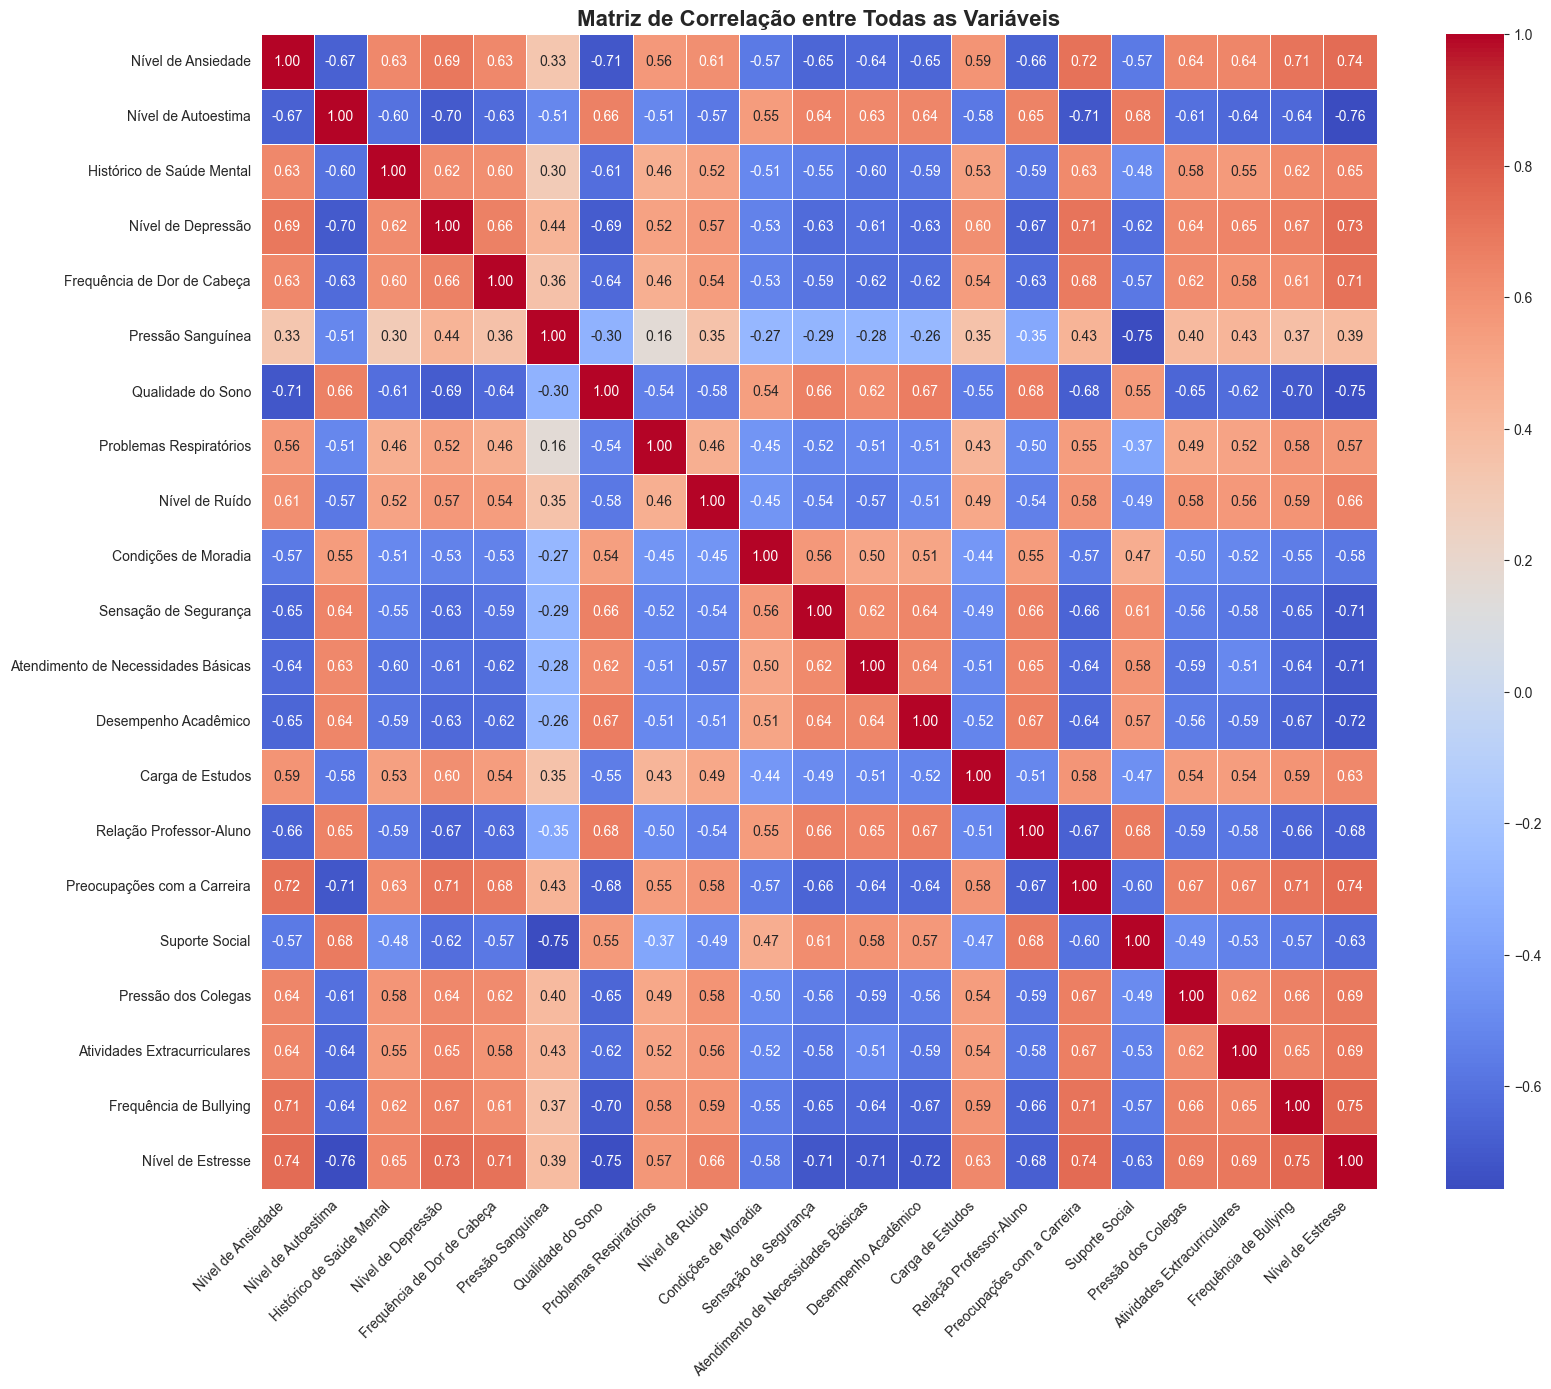

Correlação das features com 'stress_level':
Nível de Estresse                      1.000000
Frequência de Bullying                 0.751162
Preocupações com a Carreira            0.742619
Nível de Ansiedade                     0.736795
Nível de Depressão                     0.734379
Frequência de Dor de Cabeça            0.713484
Atividades Extracurriculares           0.692977
Pressão dos Colegas                    0.690684
Nível de Ruído                         0.663371
Histórico de Saúde Mental              0.648644
Carga de Estudos                       0.634156
Problemas Respiratórios                0.573984
Pressão Sanguínea                      0.394200
Condições de Moradia                  -0.581723
Suporte Social                        -0.632497
Relação Professor-Aluno               -0.680163
Atendimento de Necessidades Básicas   -0.708968
Sensação de Segurança                 -0.709602
Desempenho Acadêmico                  -0.720922
Qualidade do Sono                     -0.749

In [9]:
# --- Etapa 1: Preparação da Matriz ---

# 1. Calcular a matriz de correlação original (com os nomes em inglês)
corr_matrix = df.corr()

# 2. Criar uma cópia traduzida da matriz para usar na visualização.
#    O método .rename() aplica o dicionário tanto às colunas quanto ao índice.
#    A variável alvo "stress_level" não será traduzida, pois não está no dicionário,
#    o que é útil para mantê-la como referência.
translated_corr_matrix = corr_matrix.rename(
    columns=FEATURE_TRANSLATOR, index=FEATURE_TRANSLATOR
)


# --- Etapa 2: Visualização (Heatmap) ---

# 3. Criar o heatmap usando a matriz com os nomes traduzidos
plt.figure(figsize=(18, 15))
sns.heatmap(
    translated_corr_matrix,
    annot=True,  # Exibir os valores de correlação
    cmap="coolwarm",  # Esquema de cores (quente para positivo, frio para negativo)
    fmt=".2f",  # Formatar os números com duas casas decimais
    linewidths=0.5,  # Linhas sutis para separar as células
)
plt.title("Matriz de Correlação entre Todas as Variáveis", fontsize=16, weight="bold")
plt.xticks(
    rotation=45, ha="right"
)  # Rotaciona os rótulos do eixo X para melhor legibilidade
plt.yticks(rotation=0)
plt.show()


# --- Etapa 3: Listagem Ordenada ---

# 4. Listar as correlações com a variável alvo, também com nomes traduzidos.
#    Aplicamos o .rename() apenas no índice da Série para traduzir os nomes das features.
print("Correlação das features com 'stress_level':")
correlation_with_target = (
    corr_matrix["stress_level"].rename(FEATURE_TRANSLATOR).sort_values(ascending=False)
)
print(correlation_with_target)

**Observações:**

O mapa de calor (heatmap) e a lista de correlações com a variável alvo nos permitem tirar conclusões quantitativas sobre as relações lineares no dataset. Esta análise serve para duas finalidades principais:

1.  **Confirmar a Força dos Preditores**: Validar a intensidade da relação de cada feature com `stress_level`.
2.  **Identificar Multicolinearidade**: Verificar se existem features preditoras que são altamente correlacionadas entre si.

#### **1. Análise da Correlação com a Variável Alvo (`stress_level`)**

A lista ordenada de correlações confirma de forma numérica o que vimos nos gráficos. Podemos dividir os achados em dois grupos principais:

* **Correlações Positivas (Fatores de Risco)**:
    * As variáveis com os maiores valores positivos, como **`bullying` (0.75)**, **`future_career_concerns` (0.74)**, **`anxiety_level` (0.74)** e **`depression` (0.73)**, são os mais fortes indicadores de estresse. Um aumento no valor dessas variáveis está fortemente associado a um aumento no nível de estresse.

* **Correlações Negativas (Fatores de Proteção)**:
    * As variáveis com os valores negativos mais fortes, como **`self_esteem` (-0.76)**, **`sleep_quality` (-0.75)**, **`academic_performance` (-0.72)** e **`safety` (-0.71)**, atuam como protetores contra o estresse. Valores mais altos nessas features (melhor autoestima, melhor sono, etc.) estão fortemente associados a uma diminuição no nível de estresse.

**Conclusão Parcial**: A análise quantitativa valida integralmente as observações da análise bivariada visual. Temos um conjunto robusto de features com forte poder preditivo.

#### **2. Análise de Multicolinearidade (Features vs. Features)**

Agora, olhando para o heatmap, nosso objetivo é encontrar correlações fortes entre as variáveis preditoras (ou seja, fora da linha/coluna `stress_level`). A multicolinearidade ocorre quando duas features medem essencialmente a mesma coisa, o que pode, em alguns tipos de modelo, inflar a importância de uma variável ou tornar os resultados menos interpretáveis.

Observando os quadrados com cores mais intensas (vermelho forte ou azul escuro), podemos notar alguns pontos:

* **`basic_needs` e `safety` (0.82)**: Possuem uma correlação muito alta. Isso é intuitivo, pois a percepção de segurança está diretamente ligada ao atendimento de necessidades básicas.
* **`bullying` e `anxiety_level` (0.71)**: Também apresentam alta correlação, sugerindo que experiências de bullying estão fortemente associadas a níveis de ansiedade mais elevados.
* **`self_esteem` e `sleep_quality` (0.69)**: Uma correlação forte e interessante, indicando que uma melhor autoestima pode estar ligada a uma melhor qualidade de sono.

**Decisão Técnica**: Embora existam pontos de multicolinearidade, para os modelos que pretendemos testar inicialmente (como modelos baseados em árvores, ex: Random Forest), isso não representa um problema crítico. Esses algoritmos são robustos a esse tipo de fenômeno. Portanto, com base no princípio da simplicidade (**YAGNI** - *You Aren't Gonna Need It*), **manteremos todas as features por enquanto**. Esta análise fica registrada caso seja necessário refinar o modelo em um ciclo de otimização futuro.

### **Conclusões Finais da Fase 4: Análise Exploratória de Dados (EDA)**

A EDA foi um sucesso! Concluímos esta fase com as seguintes certezas:
1.  O dataset é de **alta qualidade**, sem dados ausentes ou duplicados.
2.  A variável alvo, `stress_level`, está **bem balanceada**.
3.  Existem **muitas features com forte correlação** (positiva e negativa) com o estresse, o que indica um grande potencial preditivo.
4.  Identificamos a presença de **multicolinearidade**, mas optamos por não tratar neste momento para manter a simplicidade.

## 4. ⚙️ Pré-processamento

Com base nas conclusões da Análise Exploratória, nosso dataset já se encontra em um estado de alta qualidade. Portanto, o pré-processamento será focado em duas etapas cruciais:

1.  **Separação das Variáveis:** Isolar as variáveis preditoras (features) da nossa variável-alvo (`stress_level`).
2.  **Divisão em Treino e Teste:** Segmentar os dados para permitir que o modelo seja treinado em um conjunto e avaliado de forma imparcial em outro.

Não será necessária a criação de novas features (engenharia de features) neste momento, pois as variáveis existentes já demonstraram um forte poder preditivo durante a EDA.

### 1. Separação de Features e Alvo

Vamos definir `X` como o conjunto de todas as colunas, exceto `stress_level`, e `y` como a coluna `stress_level`.

In [ ]:
# Definindo as features (X) e a variável alvo (y)
X = df.drop("stress_level", axis=1)
y = df["stress_level"]

# Exibindo as dimensões de X e y para verificação
print("Dimensões de X:", X.shape)
print("Dimensões de y:", y.shape)

### 2. Divisão em Dados de Treino e Teste

Agora, vamos dividir os dados em dois subconjuntos: um para treinar o modelo (80% dos dados) e outro para testá-lo em dados "inéditos" (20% dos dados).

A estratificação (`stratify=y`) é utilizada para garantir que a distribuição da variável-alvo seja a mesma nos conjuntos de treino e teste, o que é vital para uma avaliação robusta do modelo. O `random_state` é definido para garantir a reprodutibilidade dos resultados.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,  # Proporção do dataset a ser alocada para o conjunto de teste
    random_state=42,  # Semente para garantir a reprodutibilidade da divisão
    stratify=y,  # Garante a proporção das classes em ambos os conjuntos
)

# Verificando as dimensões dos conjuntos resultantes
print("Dimensões de X_train:", X_train.shape)
print("Dimensões de X_test:", X_test.shape)
print("Dimensões de y_train:", y_train.shape)
print("Dimensões de y_test:", y_test.shape)

## 5. 🤖 Modelagem

Nesta fase, iniciaremos o processo de construção de modelos de Machine Learning para prever o nível de estresse dos estudantes.

Começaremos estabelecendo um modelo de baseline, que servirá como nosso ponto de referência de desempenho. Em seguida, treinaremos e avaliaremos algoritmos mais sofisticados.

## 5.1. Modelo Baseline: Dummy Classifier

In [ ]:
# Importando as bibliotecas necessárias para modelagem e avaliação
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt

In [ ]:
# 1. Instanciar o modelo
# A estratégia 'stratified' garante que o modelo faça previsões
# que respeitam a distribuição das classes nos dados de treino.
# O random_state garante a reprodutibilidade do resultado.
baseline_model = DummyClassifier(strategy="stratified", random_state=42)

# 2. Treinar o modelo com os dados de treino
baseline_model.fit(X_train, y_train)

# 3. Fazer previsões com os dados de teste
y_pred_baseline = baseline_model.predict(X_test)

# 4. Avaliar o desempenho do modelo
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Acurácia do Modelo Baseline: {baseline_accuracy:.2f}")

# Exibir o relatório de classificação detalhado
print("\nRelatório de Classificação do Modelo Baseline:")
print(
    classification_report(
        y_test, y_pred_baseline, target_names=["Baixo", "Médio", "Alto"]
    )
)

In [ ]:
# Visualizando a Matriz de Confusão
print("Matriz de Confusão do Modelo Baseline:")
ConfusionMatrixDisplay.from_estimator(
    baseline_model, X_test, y_test, display_labels=["Baixo", "Médio", "Alto"]
)
plt.title("Matriz de Confusão - Modelo Baseline")
plt.show()

## 5.2. Modelo 1: Árvore de Decisão (Decision Tree)

Com o baseline estabelecido, vamos agora treinar nosso primeiro modelo preditivo real. A Árvore de Decisão foi escolhida por sua capacidade de aprender padrões complexos e por sua robustez à multicolinearidade identificada na EDA.

In [ ]:
# Importando o classificador de Árvore de Decisão
from sklearn.tree import DecisionTreeClassifier

# 1. Instanciar o modelo
# Usamos random_state=42 para garantir a reprodutibilidade dos resultados
tree_model = DecisionTreeClassifier(random_state=42)

# 2. Treinar o modelo com os dados de treino
tree_model.fit(X_train, y_train)

# 3. Fazer previsões com os dados de teste
y_pred_tree = tree_model.predict(X_test)

# 4. Avaliar o desempenho do modelo
tree_accuracy = accuracy_score(y_test, y_pred_tree)
print(f"Acurácia do Modelo de Árvore de Decisão: {tree_accuracy:.2f}")

# Exibir o relatório de classificação detalhado
print("\nRelatório de Classificação - Árvore de Decisão:")
print(
    classification_report(y_test, y_pred_tree, target_names=["Baixo", "Médio", "Alto"])
)

In [ ]:
# Visualizando a Matriz de Confusão
print("Matriz de Confusão - Árvore de Decisão:")
ConfusionMatrixDisplay.from_estimator(
    tree_model, X_test, y_test, display_labels=["Baixo", "Médio", "Alto"]
)
plt.title("Matriz de Confusão - Árvore de Decisão")
plt.show()

## 5.3. Modelo 2: Floresta Aleatória (Random Forest)

O modelo de Árvore de Decisão apresentou um excelente resultado. Para buscar um desempenho ainda mais robusto e diminuir o risco de overfitting, vamos treinar um modelo de ensemble: o Random Forest. Este algoritmo combina múltiplas árvores de decisão para gerar uma previsão mais estável e generalista.

In [ ]:
# Importando o classificador Random Forest
from sklearn.ensemble import RandomForestClassifier

# 1. Instanciar o modelo
# n_estimators define o número de árvores na floresta. O padrão é 100.
# Usamos random_state=42 para garantir a reprodutibilidade.
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Treinar o modelo com os dados de treino
rf_model.fit(X_train, y_train)

# 3. Fazer previsões com os dados de teste
y_pred_rf = rf_model.predict(X_test)

# 4. Avaliar o desempenho do modelo
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Acurácia do Modelo Random Forest: {rf_accuracy:.2f}")

# Exibir o relatório de classificação detalhado
print("\nRelatório de Classificação - Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=["Baixo", "Médio", "Alto"]))

In [ ]:
# Visualizando a Matriz de Confusão
print("Matriz de Confusão - Random Forest:")
ConfusionMatrixDisplay.from_estimator(
    rf_model, X_test, y_test, display_labels=["Baixo", "Médio", "Alto"]
)
plt.title("Matriz de Confusão - Random Forest")
plt.show()

## 5.4. Comparação dos Modelos e Escolha Final

Após treinar e avaliar três modelos distintos, podemos comparar seus resultados de acurácia para selecionar o mais performático.

| Modelo | Acurácia no Conjunto de Teste |
| :--- | :--- |
| Baseline (Dummy Classifier) | 35% |
| Árvore de Decisão | 85% |
| **Random Forest** | **89%** |

### Justificativa da Escolha

O modelo **Random Forest Classifier** foi escolhido como o modelo final para este projeto por três motivos principais:

1.  **Desempenho Superior:** Apresentou a maior acurácia (89%) entre os modelos testados.
2.  **Métricas Mais Robustas:** Demonstrou um `f1-score` médio superior e mais equilibrado entre as classes.
3.  **Robustez Teórica:** Como um modelo de ensemble, o Random Forest é naturalmente mais resistente ao overfitting do que uma única Árvore de Decisão, o que nos dá maior confiança de que ele generalizará bem para novos dados.

In [ ]:
import joblib

# Definindo o caminho para salvar o modelo
model_path = "../models/student_stress_rf_model.joblib"

# Salvando o objeto do modelo treinado no arquivo
joblib.dump(rf_model, model_path)

print(f"Modelo salvo com sucesso em: {model_path}")